In [33]:
import pandas as pd
import pickle
from scripts.interactive_search import *
import numpy as np
import networkx as nx
from networkx.algorithms import community
from networkx.readwrite import json_graph
import colorsys
import matplotlib.pyplot as plt
from skimage import io
import json
import math

In [2]:
# Change this function to select a different paper set
def read_metadata(path):
    df = pd.read_csv(path)
    df = df.astype({'abstract': 'str'})
    df = df[df['abstract'] != 'Unknown']
    df = df[df['abstract'] != 'nan']
    df = df[df['language'] == 'en']
    df = df[df['publish_time'].str[:4] == '2020']
    df = df.reset_index(drop=True)
    df = df[:1000]
    return df

In [3]:
load_from_pickle = True
#EMBEDDINGS_PATH = 'data/embeddings_top5k.pkl'
#EMBEDDINGS_PATH = 'data/embeddings_2020.pkl'
#EMBEDDINGS_PATH = 'data/embeddings_2020_top1k.pkl'
EMBEDDINGS_PATH = 'data/embeddings_sharp_top1k.pkl'
#METADATA_PATH = 'data/metadata_new_new.csv'
METADATA_PATH = 'data/metadata_sharp.csv'

df_meta = read_metadata(METADATA_PATH)
abstracts = [a for a in df_meta['abstract']]
titles = df_meta['title'].reset_index(drop=True)

if load_from_pickle:
    with open(EMBEDDINGS_PATH, 'rb') as file:
        embeddings = pickle.load(file)

else:
    model = SentenceTransformer(MODEL_PATH)
    embeddings = model.encode(abstracts, show_progress_bar=True)
    with open(EMBEDDINGS_PATH, 'wb') as file:
        pickle.dump(embeddings, file)

In [4]:
def compute_adjacency(embeddings, epsilon):
    cosine_distances = scipy.spatial.distance.cdist(embeddings, embeddings, "cosine")
    cosine_similarities = 1 - cosine_distances
    cosine_similarities[cosine_similarities < epsilon] = 0
    np.fill_diagonal(cosine_similarities, 0.0)
    return cosine_similarities

In [5]:
epsilon = 0.85
adjacency = compute_adjacency(embeddings, epsilon)
G = nx.from_numpy_array(adjacency)

In [6]:
index_to_title = {}
title_to_index = {}
for i in list(G.nodes):
    index_to_title.update({i: titles[i]})
    title_to_index.update({titles[i]: i})

In [7]:
G = nx.relabel.relabel_nodes(G, index_to_title)

In [8]:
def unordered_connected_components(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)
        
def connected_components(G):
    return sorted(list(unordered_connected_components(G)), key=len, reverse=True)

In [9]:
subgraphs = connected_components(G)

In [10]:
G = subgraphs[0]  # Keep only the main connected component

In [11]:
def compute_clusters_fluid(G, n_clusters=10, dtype='title'):
    clusters = []
    iterator = community.asyn_fluidc(G, n_clusters, max_iter=1)
    for cluster in iterator:
        clusters.append(cluster)

    return clusters

In [12]:
clusters = compute_clusters_fluid(G, n_clusters=3, dtype='title')  # Works quite well with high epsilon (.85) and only keeping main connected component
sum = 0
for cluster in clusters:
    sum += len(cluster)

In [13]:
title_to_cluster = {}
i = 0
for cluster in clusters:
    for title in cluster:
        if type(title) != str:
            print("Error: title is not a string => " + repr(title))
        title_to_cluster.update({title: i})
    i += 1
nx.set_node_attributes(G, title_to_cluster, "cluster")

In [14]:
for subgraph in subgraphs[1:]:
    G = nx.compose(G, subgraph)

In [90]:
layout = nx.spring_layout(G, scale = 1740, iterations=250, weight='weight', k=5, threshold=0.001)

In [91]:
def rgb(color_string):
    values = color_string[4:-1].split(",")
    r = int(values[0])
    g = int(values[1])
    b = int(values[2])
    return r, g, b

In [92]:
def rgb_string(r, g, b):
    return 'rgb(' + repr(r) + ',' + repr(g) + ',' + repr(b) + ')'

In [93]:
def merge_colors(c1, c2):
    r1, g1, b1 = rgb(c1)
    r2, g2, b2 = rgb(c2)
    
    r = int((r1+r2)/2)
    g = int((g1+g2)/2)
    b = int((b1+b2)/2)
    return r, g, b

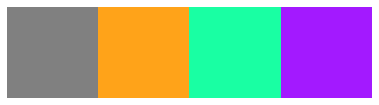

In [94]:
shift = 0.1
s = 0.9
v = 1.0
n = len(clusters)

cluster_to_color = {}
for i in range(n):
    h = (i * (1.0 / n) + shift) % 1.0
    color = colorsys.hsv_to_rgb(h, s, v)
    cluster_to_color.update({i: rgb_string(int(color[0] * 255), int(color[1] * 255), int(color[2] * 255))})
    
cluster_to_color.update({-1: 'rgb(128,128,128)'})  # Grey for nodes without a cluster

palette = np.zeros((1, n+1, 3), dtype=np.uint8)
for i in range(-1, n):
    string = cluster_to_color[i]
    r, g, b = rgb(string)
    palette[0, i+1] = np.array([r, g, b])

io.imshow(palette)
plt.axis('off')
plt.show()

In [95]:
json_G = json_graph.node_link_data(G, {'link': 'edges', 'name': 'label'})
nodes = json_G['nodes']
edges = json_G['edges']
id_to_index = {}

i = 0
for node in nodes:
    cluster = node.get('cluster', -1)
    node['x'] = layout[node['label']][0]
    node['y'] = layout[node['label']][1]
    node['id'] = str(title_to_index[node['label']])  # Note: this ID does not correspond to the ID given by gephi but it doesnt matter
    node['attributes'] = {'cluster': str(cluster)}
    if cluster != -1:
        node.pop('cluster')
    node['color'] = cluster_to_color[cluster]
    node['size'] = 10.0
    id_to_index.update({node['id']: i})
    i += 1
    
i = 0
for edge in edges:
    edge['source'] = str(title_to_index[edge['source']])
    edge['target'] = str(title_to_index[edge['target']])
    edge['id'] = str(i)  # Note: this ID does not correspond to the ID given by gephi but it doesnt matter
    edge['attributes'] = {}
    source_node = nodes[id_to_index[edge['source']]]
    target_node = nodes[id_to_index[edge['target']]]
    r, g, b = merge_colors(source_node['color'], target_node['color'])
    edge['color'] = rgb_string(r, g, b)
    edge['size'] = edge.pop('weight')
    i += 1

In [96]:
data = {'nodes': nodes, 'edges': edges}

In [97]:
JSON_PATH = 'data/data.json'
with open(JSON_PATH, 'w') as outfile:
    json.dump(data, outfile)

In [98]:
colors = np.zeros((len(nodes), 3), dtype=np.float32)
x = np.zeros((len(nodes),))
y = np.zeros((len(nodes),))
i = 0
for node in nodes:
    r, g, b = rgb(node['color'])
    colors[i] = (r/255., g/255., b/255.)
    x[i] = node['x']
    y[i] = node['y']
    i += 1

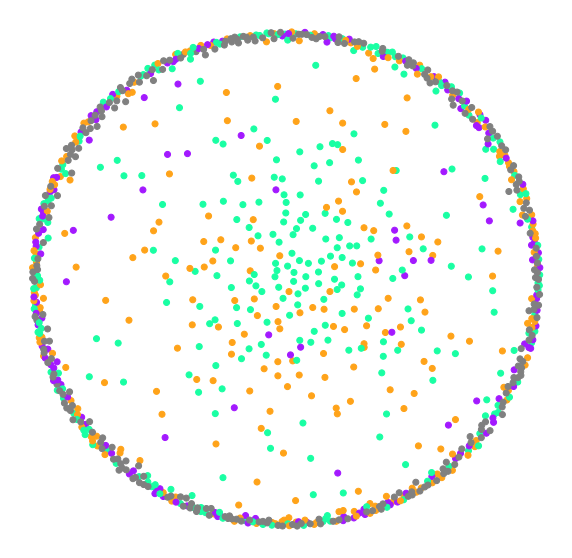

In [99]:
plt.figure(figsize=(10,10))
plt.scatter(x,y, c=colors)
plt.axis('off')
plt.show()

The end.

In [141]:
def fruchterman(G, area=10000.0, gravity=10.0, speed=100.0, seconds=10.0):
    forces = {}
    nodes = G.nodes
    edges = G.edges(data=True)
    for node in nodes:
        forces.update({node: np.array([0.0, 0.0])})
        
    layout = nx.random_layout(G)

    area = 10000
    gravity = 10.0
    speed = 1.0

    AREA_MULTIPLICATOR = 10000
    SPEED_DIVISOR = 800

    max_displace = (float) (math.sqrt(AREA_MULTIPLICATOR * area) / 10.0)
    k = float (math.sqrt((AREA_MULTIPLICATOR * area) / (1.0 + len(nodes))))

    for n1 in nodes:
        for n2 in nodes:
            if n1 != n2:
                x_dist = layout[n1][0] - layout[n2][0]
                y_dist = layout[n1][1] - layout[n2][1]
                dist = float (math.sqrt(x_dist ** 2 + y_dist ** 2))
                if dist > 0:
                    repulsive_f = (k ** 2) / dist
                    forces[n1][0] += x_dist / dist * repulsive_f
                    forces[n1][1] += y_dist / dist * repulsive_f

    for e in edges:
        n1 = e[0]
        n2 = e[1]
        x_dist = layout[n1][0] - layout[n2][0]
        y_dist = layout[n1][1] - layout[n2][1]
        dist = float (math.sqrt(x_dist ** 2 + y_dist ** 2));
        attractive_f = dist * dist / k;
        if dist > 0:
            forces[n1][0] -= x_dist / dist * attractive_f
            forces[n1][1] -= y_dist / dist * attractive_f
            forces[n2][0] += x_dist / dist * attractive_f
            forces[n2][1] += y_dist / dist * attractive_f

    for n in nodes:
        d = float (math.sqrt(layout[n][0] ** 2 + layout[n][1] ** 2))
        gf = 0.01 * k * gravity * d
        forces[n][0] -= gf * layout[n][0] / d
        forces[n][1] -= gf * layout[n][1] / d

    for n in nodes:
        forces[n][0] *= speed / SPEED_DIVISOR
        forces[n][1] *= speed / SPEED_DIVISOR

    for n in nodes:
        x_dist = forces[n][0]
        y_dist = forces[n][1]
        dist = float (math.sqrt(x_dist ** 2 + y_dist ** 2))
        if dist > 0:
            limited_dist = min(max_displace * (speed / SPEED_DIVISOR), dist)
            layout[n][0] += x_dist / dist * limited_dist
            layout[n][1] += y_dist / dist * limited_dist

    return layout

In [142]:
layout = fruchterman(G)

In [143]:
layout

{'Programmable low-cost DNA-based platform for viral RNA detection': array([0.78499013, 2.1068997 ], dtype=float32),
 'A mathematical model for simulating the transmission of Wuhan novel Coronavirus': array([ 0.35727206, -0.9876537 ], dtype=float32),
 'Genomic and protein structure modelling analysis depicts the origin and infectivity of 2019-nCoV, a new coronavirus which caused a pneumonia outbreak in Wuhan, China': array([ 1.8066483 , -0.51585394], dtype=float32),
 'Host and infectivity prediction of Wuhan 2019 novel coronavirus using deep learning algorithm': array([-1.2406002 ,  0.33399087], dtype=float32),
 'Novel ionophores active against La Crosse virus identified through rapid antiviral screening': array([ 1.5762419 , -0.29921857], dtype=float32),
 'Discovery of a novel coronavirus associated with the recent pneumonia outbreak in humans and its potential bat origin': array([-1.1077764,  0.8652343], dtype=float32),
 'Functional assessment of cell entry and receptor usage for lin

In [102]:
edges_ = G.edges(data=True)

In [107]:
for edge in edges_:
    print(edge[2])

{'weight': 0.8534114810542289}
{'weight': 0.8837083299481041}
{'weight': 0.8507320758731917}
{'weight': 0.8612439634850039}
{'weight': 0.8503483700274991}
{'weight': 0.871967480046122}
{'weight': 0.8529383595660811}
{'weight': 0.8541464833353009}
{'weight': 0.8905200072908478}
{'weight': 0.8536434153480966}
{'weight': 0.8553500091427066}
{'weight': 0.8550468676406241}
{'weight': 0.8711516150317268}
{'weight': 0.8533588189296929}
{'weight': 0.8606988839844858}
{'weight': 0.8503753133114137}
{'weight': 0.8522313521961906}
{'weight': 0.8583234703098803}
{'weight': 0.8542266808744885}
{'weight': 0.8561474697344972}
{'weight': 0.870131071438852}
{'weight': 0.8695557840399327}
{'weight': 0.8797126673630374}
{'weight': 0.8558250953300349}
{'weight': 0.8850267122312403}
{'weight': 0.8981322203257861}
{'weight': 0.862622418746029}
{'weight': 0.8795766642963726}
{'weight': 0.8640959232401855}
{'weight': 0.8852338199729461}
{'weight': 0.9327345078388926}
{'weight': 0.8982571393680088}
{'weight': 

{'weight': 0.8821008043659605}
{'weight': 0.9040293137587395}
{'weight': 0.8758773795585403}
{'weight': 0.8669033691760002}
{'weight': 0.9054933622935475}
{'weight': 0.8590119394399192}
{'weight': 0.9033564352927691}
{'weight': 0.8518920002304273}
{'weight': 0.859812403597481}
{'weight': 0.8546649507187652}
{'weight': 0.9030842177343806}
{'weight': 0.8748233354192447}
{'weight': 0.8656237735396627}
{'weight': 0.8824279243623951}
{'weight': 0.8813649096472418}
{'weight': 0.9259612409952924}
{'weight': 0.8841402037552748}
{'weight': 0.8528808066477721}
{'weight': 0.8910328956648141}
{'weight': 0.8634485087377435}
{'weight': 0.8915676732828913}
{'weight': 0.8624734914850583}
{'weight': 0.8633307487116636}
{'weight': 0.8503295670296441}
{'weight': 0.8651648388713346}
{'weight': 0.898212916623077}
{'weight': 0.8619839253306558}
{'weight': 0.9088054593048523}
{'weight': 0.8820786779505034}
{'weight': 0.88094603390994}
{'weight': 0.8781482672070662}
{'weight': 0.8741952908051233}
{'weight': 0

{'weight': 0.8635947466717508}
{'weight': 0.8550892621991171}
{'weight': 0.8677227741181258}
{'weight': 0.8831744653387203}
{'weight': 0.8900481950111196}
{'weight': 0.8568094738119594}
{'weight': 0.8898565827608819}
{'weight': 0.8996580308733916}
{'weight': 0.8663532355847714}
{'weight': 0.8580899165257976}
{'weight': 0.8637758155816465}
{'weight': 0.8910160883154356}
{'weight': 0.8799368113477748}
{'weight': 0.8919675305975424}
{'weight': 0.8506196281164239}
{'weight': 0.8550202360053287}
{'weight': 0.8559629956130672}
{'weight': 0.903530325962034}
{'weight': 0.8621301897239418}
{'weight': 0.8534635982880786}
{'weight': 0.8718627469829513}
{'weight': 0.8785201885998324}
{'weight': 0.8623978206929235}
{'weight': 0.863204000600873}
{'weight': 0.8561927074582684}
{'weight': 0.8835235664441867}
{'weight': 0.86510154155559}
{'weight': 0.8681348130251824}
{'weight': 0.8556049809704206}
{'weight': 0.863203119740881}
{'weight': 0.8825035869996121}
{'weight': 0.8950836507041976}
{'weight': 0.

{'weight': 0.8508247803913179}
{'weight': 0.852802351038867}
{'weight': 0.8535283005586791}
{'weight': 0.8691549446986933}
{'weight': 0.8545905477972897}
{'weight': 0.8607161554369863}
{'weight': 0.8839188399025514}
{'weight': 0.8899178231731634}
{'weight': 0.8625448733573473}
{'weight': 0.8653202845740129}
{'weight': 0.8811622758830494}
{'weight': 0.8949053029780948}
{'weight': 0.8930218467262002}
{'weight': 0.8699657929616159}
{'weight': 0.8723165435544201}
{'weight': 0.85368352184002}
{'weight': 0.8697364290861223}
{'weight': 0.8670017863885212}
{'weight': 0.9092231586225004}
{'weight': 0.8551643025688866}
{'weight': 0.8805561374366314}
{'weight': 0.9037211416111952}
{'weight': 0.8783967114060769}
{'weight': 0.8580945127655666}
{'weight': 0.8822318563914717}
{'weight': 0.8618341708042652}
{'weight': 0.8823341074429947}
{'weight': 0.9117653092192153}
{'weight': 0.8918770195611598}
{'weight': 0.8712115255901679}
{'weight': 0.8723355715343809}
{'weight': 0.8543429713434285}
{'weight': 

{'weight': 0.8640009940778153}
{'weight': 0.9038972145313411}
{'weight': 0.8684125813623864}
{'weight': 0.9072307976568362}
{'weight': 0.8634962971017675}
{'weight': 0.8656552783376048}
{'weight': 0.8675018380126415}
{'weight': 0.8509452394926138}
{'weight': 0.8536033433264193}
{'weight': 0.8835661068163142}
{'weight': 0.8679872879300082}
{'weight': 0.8522809147246461}
{'weight': 0.9152814413084229}
{'weight': 0.8679100844737291}
{'weight': 0.8606902717281146}
{'weight': 0.8541641875861229}
{'weight': 0.8771183097196956}
{'weight': 0.8677463220316646}
{'weight': 0.8677887259791193}
{'weight': 0.8798017155883318}
{'weight': 0.883350563121212}
{'weight': 0.8614110963688328}
{'weight': 0.8571213063746294}
{'weight': 0.8533738626217378}
{'weight': 0.8603624193043146}
{'weight': 0.8710907920711113}
{'weight': 0.9114388197429141}
{'weight': 0.8666435592617681}
{'weight': 0.9036126573004638}
{'weight': 0.850635674286028}
{'weight': 0.9036017178426176}
{'weight': 0.8602080165890397}
{'weight':

{'weight': 0.8536808462681408}
{'weight': 0.8590919475286959}
{'weight': 0.8995401253325226}
{'weight': 0.8621424990224275}
{'weight': 0.8566346580464022}
{'weight': 0.8767634019255973}
{'weight': 0.9022421133818747}
{'weight': 0.9185874433551886}
{'weight': 0.8920022702888512}
{'weight': 0.91913250302596}
{'weight': 0.8711063149544616}
{'weight': 0.8900524103071614}
{'weight': 0.877267470580461}
{'weight': 0.8807575601392651}
{'weight': 0.8698373240603854}
{'weight': 0.8911795555170455}
{'weight': 0.8817813342845741}
{'weight': 0.8914890406888443}
{'weight': 0.8662121351841011}
{'weight': 0.8594019876957726}
{'weight': 0.8693501377103364}
{'weight': 0.8765605687866707}
{'weight': 0.8962336455575117}
{'weight': 0.8853800495403199}
{'weight': 0.8704609334631401}
{'weight': 0.88797181066716}
{'weight': 0.854688695053215}
{'weight': 0.8939428566480684}
{'weight': 0.9007077458916055}
{'weight': 0.8589892351955438}
{'weight': 0.904672483308357}
{'weight': 0.8767924339545775}
{'weight': 0.85

{'weight': 0.8747855903963788}
{'weight': 0.8851314424764235}
{'weight': 0.8504744299393056}
{'weight': 0.8592016278015414}
{'weight': 0.8529266574825406}
{'weight': 0.8747621394096902}
{'weight': 0.8690398759028529}
{'weight': 0.8502752862650556}
{'weight': 0.8815812104916889}
{'weight': 0.8660176728432727}
{'weight': 0.8656681312359364}
{'weight': 0.878932228762906}
{'weight': 0.8528517736241674}
{'weight': 0.8662533596134588}
{'weight': 0.8676037437854762}
{'weight': 0.8565057712153676}
{'weight': 0.8942127650594106}
{'weight': 0.8592418854771293}
{'weight': 0.8546059724522362}
{'weight': 0.8632554227161002}
{'weight': 0.8601661507828302}
{'weight': 0.8639844674150502}
{'weight': 0.850100127969197}
{'weight': 0.860602431570577}
{'weight': 0.8639758068122995}
{'weight': 0.8828787351326172}
{'weight': 0.8625898187206408}
{'weight': 0.8763725171365184}
{'weight': 0.8626995927597618}
{'weight': 0.8506879070690478}
{'weight': 0.8672982717948816}
{'weight': 0.8579728398301268}
{'weight': 

In [ ]:
public float dx = 0;
    public float dy = 0;
    public float old_dx = 0;
    public float old_dy = 0;
    public float freeze = 0f;

In [31]:
np.array([0.0, 0.0])

array([0., 0.])

In [25]:
def fruchterman(area=10000.0, gravity=10.0, speed=1.0, seconds=10.0):
    return

In [ ]:
@Override
    public void goAlgo() {
        this.graph = graphModel.getGraphVisible();
        graph.readLock();
        try {
            Node[] nodes = graph.getNodes().toArray();
            Edge[] edges = graph.getEdges().toArray();

            for (Node n : nodes) {
                if (n.getLayoutData() == null || !(n.getLayoutData() instanceof ForceVectorNodeLayoutData)) {
                    n.setLayoutData(new ForceVectorNodeLayoutData());
                }
                ForceVectorNodeLayoutData layoutData = n.getLayoutData();
                layoutData.dx = 0;
                layoutData.dy = 0;
            }

            float maxDisplace = (float) (Math.sqrt(AREA_MULTIPLICATOR * area) / 10f);                    // Déplacement limite : on peut le calibrer...
            float k = (float) Math.sqrt((AREA_MULTIPLICATOR * area) / (1f + nodes.length));        // La variable k, l'idée principale du layout.

            for (Node N1 : nodes) {
                for (Node N2 : nodes) {    // On fait toutes les paires de noeuds
                    if (N1 != N2) {
                        float xDist = N1.x() - N2.x();    // distance en x entre les deux noeuds
                        float yDist = N1.y() - N2.y();
                        float dist = (float) Math.sqrt(xDist * xDist + yDist * yDist);    // distance tout court

                        if (dist > 0) {
                            float repulsiveF = k * k / dist;            // Force de répulsion
                            ForceVectorNodeLayoutData layoutData = N1.getLayoutData();
                            layoutData.dx += xDist / dist * repulsiveF;        // on l'applique...
                            layoutData.dy += yDist / dist * repulsiveF;
                        }
                    }
                }
            }
            for (Edge E : edges) {
                // Idem, pour tous les noeuds on applique la force d'attraction

                Node Nf = E.getSource();
                Node Nt = E.getTarget();

                float xDist = Nf.x() - Nt.x();
                float yDist = Nf.y() - Nt.y();
                float dist = (float) Math.sqrt(xDist * xDist + yDist * yDist);

                float attractiveF = dist * dist / k;

                if (dist > 0) {
                    ForceVectorNodeLayoutData sourceLayoutData = Nf.getLayoutData();
                    ForceVectorNodeLayoutData targetLayoutData = Nt.getLayoutData();
                    sourceLayoutData.dx -= xDist / dist * attractiveF;
                    sourceLayoutData.dy -= yDist / dist * attractiveF;
                    targetLayoutData.dx += xDist / dist * attractiveF;
                    targetLayoutData.dy += yDist / dist * attractiveF;
                }
            }
            // gravity
            for (Node n : nodes) {
                ForceVectorNodeLayoutData layoutData = n.getLayoutData();
                float d = (float) Math.sqrt(n.x() * n.x() + n.y() * n.y());
                float gf = 0.01f * k * (float) gravity * d;
                layoutData.dx -= gf * n.x() / d;
                layoutData.dy -= gf * n.y() / d;
            }
            // speed
            for (Node n : nodes) {
                ForceVectorNodeLayoutData layoutData = n.getLayoutData();
                layoutData.dx *= speed / SPEED_DIVISOR;
                layoutData.dy *= speed / SPEED_DIVISOR;
            }
            for (Node n : nodes) {
                // Maintenant on applique le déplacement calculé sur les noeuds.
                // nb : le déplacement à chaque passe "instantanné" correspond à la force : c'est une sorte d'accélération.
                ForceVectorNodeLayoutData layoutData = n.getLayoutData();
                float xDist = layoutData.dx;
                float yDist = layoutData.dy;
                float dist = (float) Math.sqrt(layoutData.dx * layoutData.dx + layoutData.dy * layoutData.dy);
                if (dist > 0 && !n.isFixed()) {
                    float limitedDist = Math.min(maxDisplace * ((float) speed / SPEED_DIVISOR), dist);
                    n.setX(n.x() + xDist / dist * limitedDist);
                    n.setY(n.y() + yDist / dist * limitedDist);
                }
            }
        } finally {
            graph.readUnlockAll();
        }
    }